In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
np.seterr(over="raise")
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

zcross = lambda A: d3.MulCosine(d3.skew(A))
from mydedalustools import *

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


In [5]:
(200e3)**8/86400

2.962962962962963e+37

In [1]:
(40e15*86400)**0.25

242461.8605611948

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1

# Earth parameters
R_E = 6.4e6*meter
Omega_E = 2*np.pi/86400 / second
Omega = Omega_E
R = R_E

# Set Parameters
Ro_T = 10.
E = 0.02
tau_rad_nondim = 200
mu = 0.05

# diagnostic parameters
cp = 1004 * meter**2 / second**2 / Kelvin
P1 = 0.25**(0.286)
P2 = 0.75**(0.286)

DeltaTheta = Ro_T*(2*Omega*R)**2/cp
DeltaThetaVertical = mu*DeltaTheta
taurad = tau_rad_nondim/(2*Omega)
taudrag = 1/(2*Omega*E)


Now let's build two bases for the sphere. First, one to just represent zonally constant fields, and second, one to represent full 2D fields on the sphere:

In [3]:
Nphi = 64; Ntheta = 32
dealias = (3/2, 3/2)
dtype = np.float64

# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)

# Thermal wind balance solution with $\theta_1 = \theta_{1E}$, $\theta_2 = \theta_{2E}$

In [68]:
template_u = open_h5('snapshots_2level_T21_locked_3_p02_400_p05','s1').u1[0]*0
template_theta = open_h5('snapshots_2level_T21_locked_3_p02_400_p05','s1').theta1[0]*0

In [69]:
u1      = dist.VectorField(coords, name='u1', bases=full_basis)
theta1E = dist.Field(name='theta1E', bases=full_basis)
theta2E = dist.Field(name='theta2E', bases=full_basis)

problem = d3.LBVP([u1], namespace=locals())
problem.add_equation("2*Omega*zcross(u1) = - grad(cp*(P2-P1)*(theta1E+theta2E)/2)")

phi, theta = dist.local_grids(full_basis)
lat = np.pi / 2 - theta + 0*phi
lon = phi-np.pi
theta1E['g'] = DeltaThetaVertical+DeltaTheta*np.cos(lat)*np.cos(lon)*(np.cos(lon)>=0)
theta2E['g'] = DeltaTheta*np.cos(lat)*np.cos(lon)*(np.cos(lon)>=0)

solver = problem.build_solver()
solver.solve()

u1     .change_scales(1)
theta1E.change_scales(1)
theta2E.change_scales(1)

u1_tw = template_u + u1['g']
theta1_tw = template_theta + theta1E['g']
theta2_tw = template_theta + theta2E['g']

2023-07-25 07:06:54,071 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2023-07-25 07:06:54,086 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 1.9e+02/s
2023-07-25 07:06:54,110 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+02/s
2023-07-25 07:06:54,141 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+02/s
2023-07-25 07:06:54,162 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+02/s
2023-07-25 07:06:54,183 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+02/s
2023-07-25 07:06:54,206 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+02/s
2023-07-25 07:06:54,236 subsystems 0/1 INFO :: Building subproblem matric

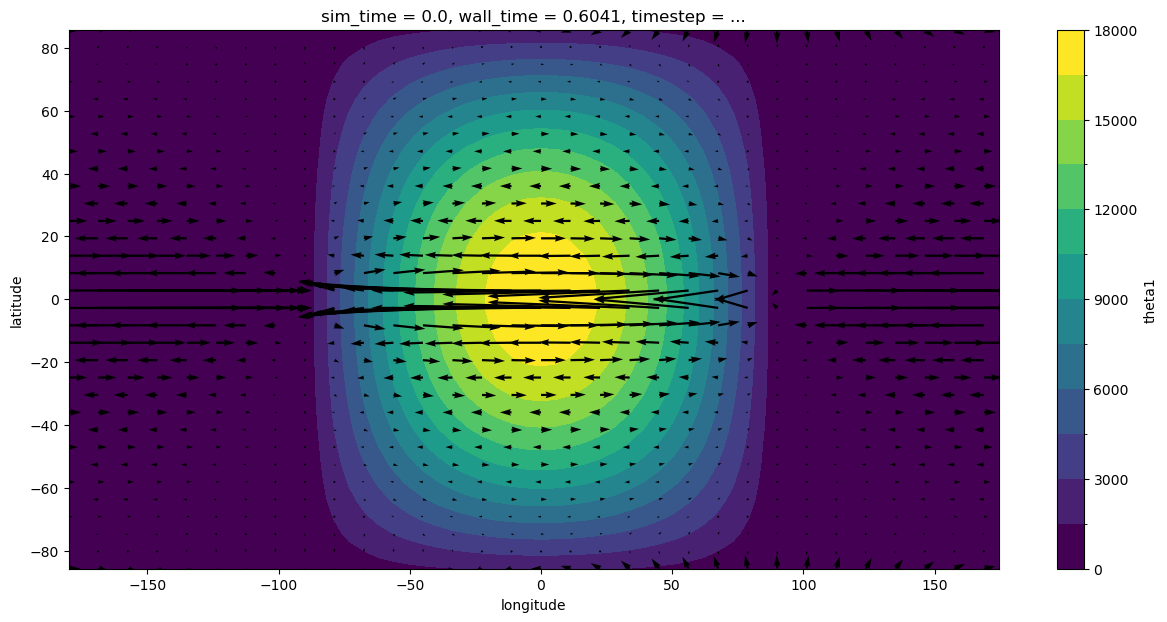

In [72]:
def plot_one_theta_wind(ax,theta,wind,vmin=None,vmax=None,cmap = plt.cm.viridis,scale=None,wind_disc=1):
        ((theta)/Kelvin).plot.contourf(ax=ax,y='latitude',levels=18,cmap=cmap,vmin=vmin,vmax=vmax)
        n=2*wind_disc;m=wind_disc
        ax.quiver(wind.longitude[::n],
                  wind.latitude[::m] ,
                  wind[0][::n,::m].T,
                  -wind[1][::n,::m].T,
                  scale=scale)
        
_,ax=plt.subplots(figsize=(15,7))
plot_one_theta_wind(ax,theta1_tw+theta2_tw,u1_tw,vmin=None,vmax=None,cmap = plt.cm.viridis,scale=None,wind_disc=1)

# Thermally-direct solution with IVP?

In [79]:
u1       = dist.VectorField(coords, name='u1', bases=full_basis)
u2       = dist.VectorField(coords, name='u2', bases=full_basis)
Phi1     = dist.Field(name='Phi1'  , bases=full_basis)
theta1E  = dist.Field(name='theta1E', bases=full_basis)
theta2E  = dist.Field(name='theta2E', bases=full_basis)
tau_Phi1 = dist.Field(name='tau_Phi1')

problem = d3.NLBVP([u1,u2,Phi1,tau_Phi1], namespace=locals())
problem.add_equation("nu*lap(lap(u1)) + grad(Phi1) = - u1@grad(u1) - div(u2)/2*(u2-u1)")
problem.add_equation("nu*lap(lap(u2)) + grad(Phi1) = - u2@grad(u2) - div(u2)/2*(u2-u1) + grad( (P2-P1)*cp*(theta1E+theta2E)/2 )")
problem.add_equation("div(u1+u2) + tau_Phi1 = 0")
problem.add_equation("ave(Phi1) = 0")

phi, theta = dist.local_grids(full_basis)
lat = np.pi / 2 - theta + 0*phi
lon = phi-np.pi
theta1E['g'] = DeltaThetaVertical+DeltaTheta*np.cos(lat)*np.cos(lon)*(np.cos(lon)>=0)
theta2E['g'] = DeltaTheta*np.cos(lat)*np.cos(lon)*(np.cos(lon)>=0)

nu = 40e15*meter**4/second * (R/R_E)**4 * (Omega/Omega_E)

ncc_cutoff = 1e-7
tolerance = 6e-3
u1      .change_scales(dealias)
u2      .change_scales(dealias)
Phi1    .change_scales(dealias)
theta1E .change_scales(dealias)
theta2E .change_scales(dealias)
tau_Phi1.change_scales(dealias)

solver = problem.build_solver(ncc_cutoff=ncc_cutoff),
pert_norm = np.inf

while pert_norm > tolerance:
    solver[0].newton_iteration(damping=1)
    pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver[0].perturbations)
    logger.info(f'Perturbation norm: {pert_norm:.3e}')

    


NotImplementedError: Only last-axis NCCs implemented for this basis.

In [83]:
u1     = dist.VectorField(coords, name='u1', bases=full_basis)
u2     = dist.VectorField(coords, name='u2', bases=full_basis)
Phi1   = dist.Field(name='Phi1'  , bases=full_basis)
theta1E = dist.Field(name='theta1E', bases=full_basis)
theta2E = dist.Field(name='theta2E', bases=full_basis)
tau_Phi1 = dist.Field(name='tau_Phi1')

problem = d3.IVP([u1,u2,Phi1,tau_Phi1], namespace=locals())
problem.add_equation("dt(u1) + nu*lap(lap(u1)) + grad(Phi1) = - u1@grad(u1) - div(u2)/2*(u2-u1)")
problem.add_equation("dt(u2) + nu*lap(lap(u2)) + grad(Phi1) = - u2@grad(u2) - div(u2)/2*(u2-u1) + grad( (P2-P1)*cp*(theta1E+theta2E)/2 )")
problem.add_equation("div(u1+u2) + tau_Phi1 = 0")
problem.add_equation("ave(Phi1) = 0")

phi, theta = dist.local_grids(full_basis)
lat = np.pi / 2 - theta + 0*phi
lon = phi-np.pi
theta1E['g'] = DeltaThetaVertical+DeltaTheta*np.cos(lat)*np.cos(lon)*(np.cos(lon)>=0)
theta2E['g'] = DeltaTheta*np.cos(lat)*np.cos(lon)*(np.cos(lon)>=0)

nu = 1e3*40e15*meter**4/second * (R/R_E)**4 * (Omega/Omega_E)

solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = 100*hour
timestep = 100*second
it=0
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            #theta1.change_scales(1)
            #template[it] = theta1['g']; it+=1
            #theta1.change_scales(dealias)
except:
    logger.info('Last dt=%e' %(timestep))
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


2023-07-25 08:53:43,158 subsystems 0/1 INFO :: Building subproblem matrices 1/31 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.8e+01/s
2023-07-25 08:53:43,184 subsystems 0/1 INFO :: Building subproblem matrices 4/31 (~13%) Elapsed: 0s, Remaining: 0s, Rate: 8.5e+01/s
2023-07-25 08:53:43,221 subsystems 0/1 INFO :: Building subproblem matrices 8/31 (~26%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+01/s
2023-07-25 08:53:43,259 subsystems 0/1 INFO :: Building subproblem matrices 12/31 (~39%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s
2023-07-25 08:53:43,293 subsystems 0/1 INFO :: Building subproblem matrices 16/31 (~52%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2023-07-25 08:53:43,327 subsystems 0/1 INFO :: Building subproblem matrices 20/31 (~65%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2023-07-25 08:53:43,361 subsystems 0/1 INFO :: Building subproblem matrices 24/31 (~77%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2023-07-25 08:53:43,396 subsystems 0/1 INFO :: Building subproblem matric

FloatingPointError: overflow encountered in multiply

In [84]:
u1     .change_scales(1)
theta1E.change_scales(1)
theta2E.change_scales(1)

u1_tw = template_u + u1['g']
theta1_tw = template_theta + theta1E['g']
theta2_tw = template_theta + theta2E['g']

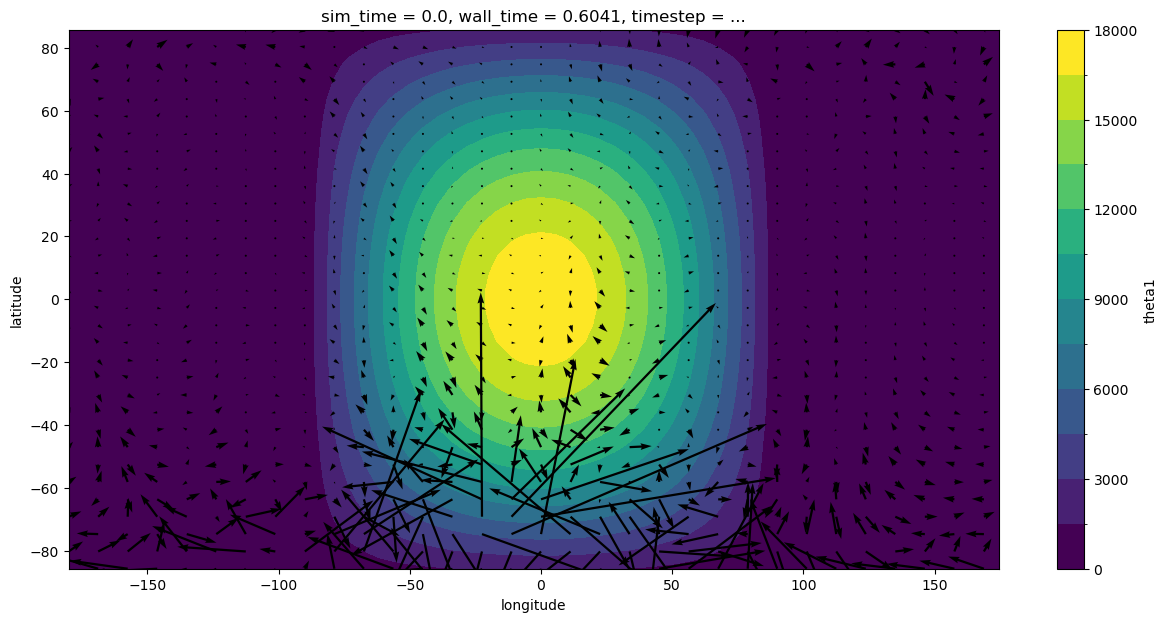

In [85]:
def plot_one_theta_wind(ax,theta,wind,vmin=None,vmax=None,cmap = plt.cm.viridis,scale=None,wind_disc=1):
        ((theta)/Kelvin).plot.contourf(ax=ax,y='latitude',levels=18,cmap=cmap,vmin=vmin,vmax=vmax)
        n=2*wind_disc;m=wind_disc
        ax.quiver(wind.longitude[::n],
                  wind.latitude[::m] ,
                  wind[0][::n,::m].T,
                  -wind[1][::n,::m].T,
                  scale=scale)
        
_,ax=plt.subplots(figsize=(15,7))
plot_one_theta_wind(ax,theta1_tw+theta2_tw,u1_tw,vmin=None,vmax=None,cmap = plt.cm.viridis,scale=None,wind_disc=1)

# Eigenmodes - old

In [29]:
taurad = 1*day

In [30]:
# Perturbation fields
u11 = dist.VectorField(coords, name='u11', bases=full_basis)
h11 = dist.Field(name='h11', bases=full_basis)
u21 = dist.VectorField(coords, name='u21', bases=full_basis)
h21 = dist.Field(name='h21', bases=full_basis)
sigma = dist.Field(name='sigma')  # eigenvalue

# Parameters
nu = 1e5 * meter**2 / second / 32**2 # Hyperdiffusion constant

# Eigenvalue problem
problem = d3.EVP([u11,u21, h11,h21], eigenvalue=sigma, namespace=locals())
problem.add_equation("sigma*u11 + u11@grad(u10) + u10@grad(u11) + nu*lap(lap(u11)) + g*grad(h11+h21) + 2*Omega*zcross(u11) = 0")
problem.add_equation("sigma*u21 + u21@grad(u20) + u20@grad(u21) + nu*lap(lap(u21)) + g*grad(h11+h21) + gprime*grad(h21) + 2*Omega*zcross(u21) = 0")
problem.add_equation("sigma*h11 + div(h10*u11) + div(h11*u10) + nu*lap(lap(h11)) + h11/taurad = 0");
problem.add_equation("sigma*h21 + div(h20*u21) + div(h21*u20) + nu*lap(lap(h21)) + h21/taurad = 0");




The eigenvalue solver (like all solvers in Dedalus) splits up the problem into its *linearly separable subproblems*.
Each of these *subproblems* is represented by a separate matrix -- these are the things constructed when you build a solver object, and together these form the diagonal blocks of the total linear system.
Here we have NCCs (the background flow) that depend on the latitude, meaning the system is linearly coupled over all $\ell$ for each $m$.

In any event, the eigenvalue solver allows you to find the eigenvalues for each subproblem independently.
The subproblems are objects in the `solver.subproblems` list.
Each has a `.group` attribute that describes the corresponding mode (wavenumber or spherical harmonic order/degree).
You can use the `solver.subproblems_by_group` dictionary to find the object associated with a given horizontal mode, here in the form `(m, None)` to indicate the matrices that couple all $\ell$ for a given $m$.

Here lets loop over the subproblems and compute the fastest growing mode for the first 15 spherical harmonic orders.

In [31]:
%%time
# Eigenvalue solver
m_max = 7
growth_rate = np.zeros(m_max + 1)
solver = problem.build_solver()
for m in range(m_max + 1):
    sp = solver.subproblems_by_group[(m, None)]
    solver.solve_dense(sp)
    growth_rate[m] = np.max(solver.eigenvalues.real)

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


2023-07-11 13:23:07,261 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.6e-01/s
2023-07-11 13:23:10,495 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 5.1e-01/s
2023-07-11 13:23:13,913 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:17,549 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.8e-01/s
2023-07-11 13:23:21,016 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:24,477 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:27,866 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 4.9e-01/s
2023-07-11 13:23:31,170 subsystems 0/1 INFO :: Building subproblem matrices 

Now let's plot the growth rates:

Text(0, 0.5, 'growth rate')

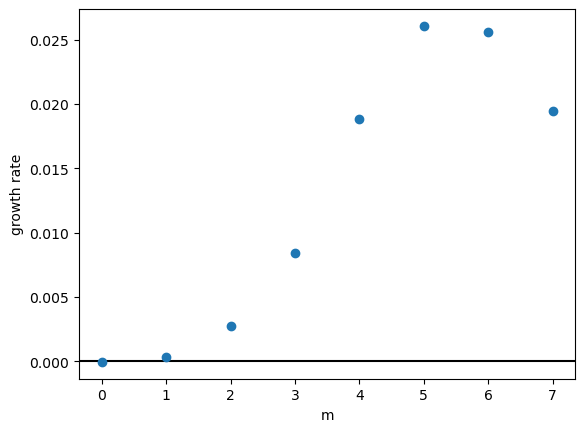

In [32]:
plt.figure()
plt.axhline(0, c='k')
plt.plot(np.arange(m_max + 1), growth_rate, 'o')
plt.xlabel('m')
plt.ylabel('growth rate')

In [39]:
sp = solver.subproblems_by_group[(6, None)]
solver.solve_dense(sp)
index = np.argmax(solver.eigenvalues.real)
solver.set_state(index, sp.subsystems[0])

Now we can plot e.g. the height perturbation in the eigenmode:

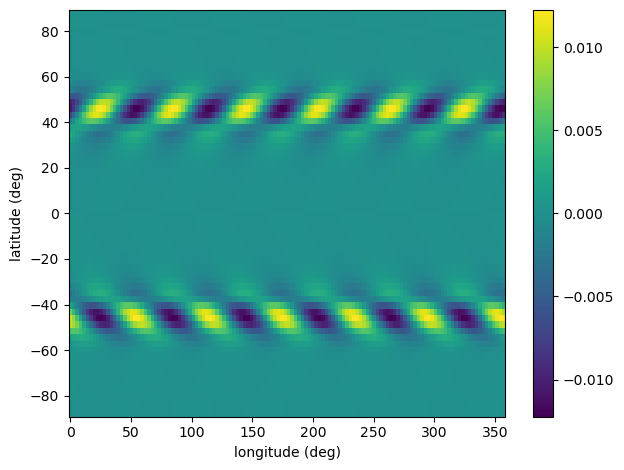

In [40]:
phi, theta = dist.local_grids(full_basis)
latitude = (np.pi / 2 - theta) / np.pi * 180
longitude = phi / np.pi * 180
plt.figure()
plt.pcolormesh(longitude.ravel(), latitude.ravel(), h11['g'].T)
plt.xlabel('longitude (deg)')
plt.ylabel('latitude (deg)')
plt.colorbar()
plt.tight_layout()